<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/halloween-seminar-2023/blob/main/1_notebooks/chapter-04-01.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Understanding Simple LSTM Neural Networks in Keras

## Import Libraries

In [1]:
from pandas import read_csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

## Running the LSTM on Sunspots Dataset

 Let’s run a complete RNN on a simple time series dataset. We’ll need to follow these steps:

- Read the dataset from a given URL
- Split the data into training and test sets
- Prepare the input to the required Keras format
- Create an RNN model and train it
- Make the predictions on training and test sets and print the root mean square error on both sets
- View the result

**Step 1, 2: Reading Data and Splitting Into Train and Test**

The following function reads the train and test data from a given URL and splits it into a given percentage of train and test data. It returns single-dimensional arrays for train and test data after scaling the data between 0 and 1 using MinMaxScaler from scikit-learn.

In [2]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(url, split_percent=0.8):
    df     = read_csv(url, usecols=[1], engine='python')
    data   = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data   = scaler.fit_transform(data).flatten()
    n      = len(data)
    # Point for splitting data into train and test
    split      = int(n*split_percent)
    train_data = data[range(split)]
    test_data  = data[split:]
    return train_data, test_data, data

**Step 3: Reshaping Data for Keras**

The next step is to prepare the data for Keras model training. The input array should be shaped as: total_samples x time_steps x features.

There are many ways of preparing time series data for training. We’ll create input rows with non-overlapping time steps. An example for time steps = 2 is shown in the figure below. Here, time steps denotes the number of previous time steps to use for predicting the next value of the time series data.

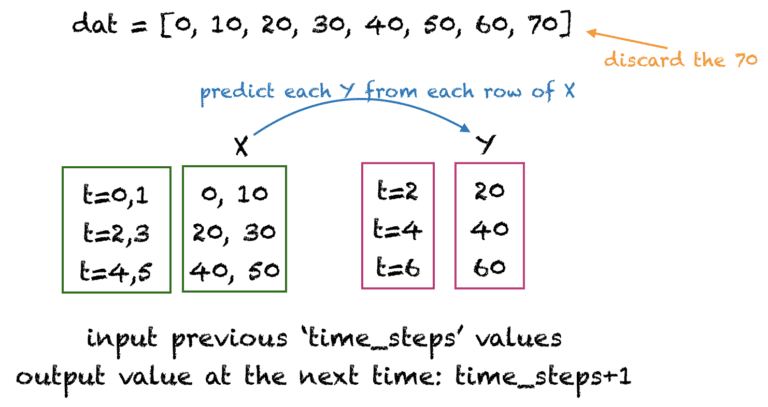

*(source: "Understanding Simple Recurrent Neural Networks in Keras" by Mehreen Saeed, Machine Learning Mastery)* 

The following function `get_XY()` takes a one-dimensional array as input and converts it to the required input X and target Y arrays. We’ll use 12 time_steps for the sunspots dataset as the sunspots generally have a cycle of 12 months. You can experiment with other values of time_steps.

In [3]:
# Prepare the input X and target Y
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y

**Step 4: Create RNN Model and Train**

The function below returns a model that includes a SimpleRNN layer and a Dense layer for learning sequential data. The input_shape specifies the parameter (time_steps x features). We’ll simplify everything and use univariate data, i.e., one feature only; the time steps are discussed below.

In [4]:
def create_LSTM(time_steps):
    model = Sequential()
    # The first LSTM layer with 50 units and the input shape (time_steps, 1) is added. 
    # This layer is configured to return sequences using the return_sequences=True parameter. 
    # It means this layer will produce output sequences for each time step in the input sequence.
    model.add(LSTM(50, input_shape=(time_steps, 1), return_sequences=True))
    # After each LSTM layer, a dropout layer is added with a dropout rate of 0.2. Dropout is 
    # a regularization technique that helps prevent overfitting by randomly "dropping out" 
    # a fraction of neurons during training.
    model.add(Dropout(0.2))
    # The second LSTM layer with 50 units is added. It also returns sequences.
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    # The third LSTM layer with 50 units is added, but this time it's configured to return only the final output, 
    # not sequences.
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    # A single dense layer with one output unit is added. This layer is typically used for regression tasks, 
    # where the model predicts a continuous numeric value.
    model.add(Dense(1))
    model.summary()    
    # The model is configured for training. It uses mean squared error (MSE) as the loss function, 
    # which is a common choice for regression problems. The 'adam' optimizer is used for gradient 
    # descent optimization.
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

**Step 5: Compute and Print the Root Mean Square Error**

The function print_error() computes the mean square error between the actual and predicted values.

In [21]:
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    

**Step 6: View the Result**

The following function plots the actual target values and the predicted values. The red line separates the training and test data points.

In [22]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

In [23]:
sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
time_steps   = 12
train_data, test_data, data = get_train_test(sunspots_url)
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

In [24]:
# Create model and train
model = create_LSTM(time_steps)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 12, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 12, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 12, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 12, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                

In [25]:
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
187/187 - 7s - loss: 0.0101 - 7s/epoch - 37ms/step
Epoch 2/20
187/187 - 2s - loss: 0.0093 - 2s/epoch - 8ms/step
Epoch 3/20
187/187 - 2s - loss: 0.0082 - 2s/epoch - 9ms/step
Epoch 4/20
187/187 - 2s - loss: 0.0072 - 2s/epoch - 9ms/step
Epoch 5/20
187/187 - 2s - loss: 0.0069 - 2s/epoch - 8ms/step
Epoch 6/20
187/187 - 2s - loss: 0.0071 - 2s/epoch - 9ms/step
Epoch 7/20
187/187 - 2s - loss: 0.0058 - 2s/epoch - 9ms/step
Epoch 8/20
187/187 - 2s - loss: 0.0068 - 2s/epoch - 9ms/step
Epoch 9/20
187/187 - 2s - loss: 0.0062 - 2s/epoch - 8ms/step
Epoch 10/20
187/187 - 2s - loss: 0.0055 - 2s/epoch - 9ms/step
Epoch 11/20
187/187 - 2s - loss: 0.0055 - 2s/epoch - 10ms/step
Epoch 12/20
187/187 - 2s - loss: 0.0057 - 2s/epoch - 10ms/step
Epoch 13/20
187/187 - 2s - loss: 0.0049 - 2s/epoch - 9ms/step
Epoch 14/20
187/187 - 2s - loss: 0.0051 - 2s/epoch - 9ms/step
Epoch 15/20
187/187 - 2s - loss: 0.0057 - 2s/epoch - 9ms/step
Epoch 16/20
187/187 - 2s - loss: 0.0054 - 2s/epoch - 8ms/step
Epoch 17/20
18

2/2 [==============================] - 0s 8ms/step
Train RMSE: 0.059 RMSE
Test RMSE: 0.082 RMSE


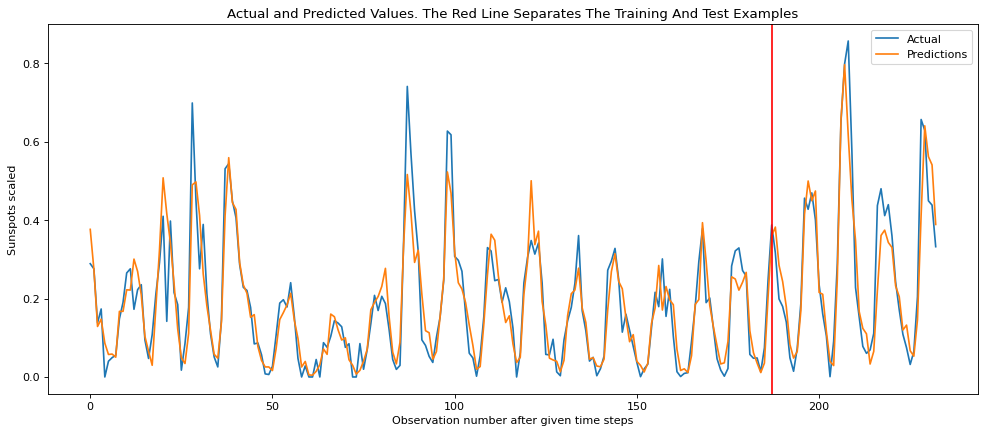

In [26]:
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Print error
print_error(trainY, testY, train_predict, test_predict)

#Plot result
plot_result(trainY, testY, train_predict, test_predict)

## Reference and Credits

-  Mehreen Saeed **[Understanding Simple Recurrent Neural Networks in Keras](https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/)**, Machine Learning Mastery
---
-  Mehreen Saeed **[An Introduction to Recurrent Neural Networks and the Math That Powers Them](https://machinelearningmastery.com/an-introduction-to-recurrent-neural-networks-and-the-math-that-powers-them/)**, Machine Learning Mastery